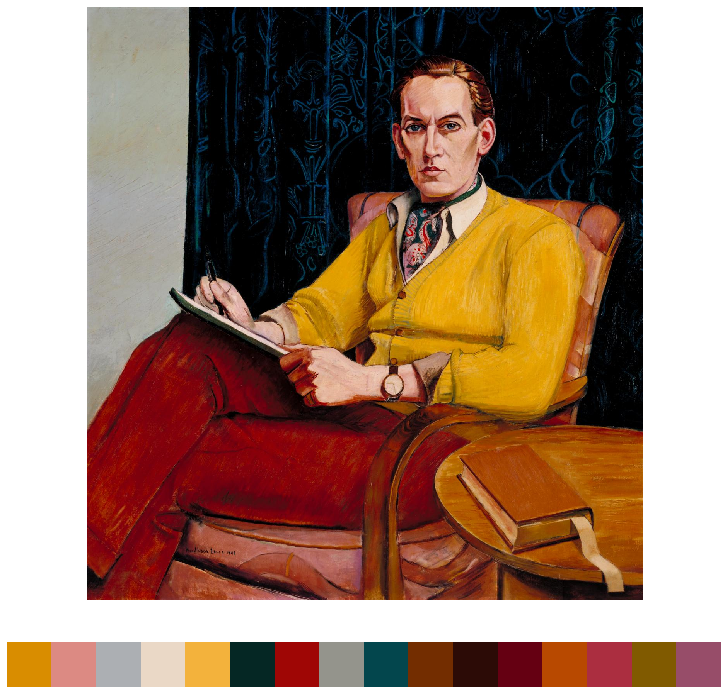

T04118


In [2]:
import numpy as np
import glob
import random
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from skimage import io

def parse_collist(filename):
    res = []
    with open(filename, 'r') as f:
        for l in f:
            col = [int(s) for s in l[:-1].split()]
            res.append(col)
    return np.array(res)

def image_files():
    for f in glob.glob('paintings/*.txt'):
        if f.count('.') == 1: # Filters out non-images
            yield f


filename = random.choice(list(image_files()))
_id = Path(filename).stem

img = io.imread('paintings/{}.jpg'.format(_id))

cols = parse_collist(filename)

fig = plt.figure(constrained_layout=True, figsize=(10,10))
k = 5
gs = gridspec.GridSpec(k+1, k, figure=fig)
axes = [None]*2

axes[0] = plt.subplot(gs[:k,:k])
axes[1] = plt.subplot(gs[k,:])

axes[0].imshow(img)
axes[1].imshow([cols])
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    for s in ax.spines:
        ax.spines[s].set_visible(False)
plt.show()
print(_id)

<h2>Collect dataset</h2>

In [3]:
import pandas as pd

collection = pd.read_csv("tate/collection.csv", index_col=0)
details = pd.read_csv("details.csv", index_col=0)

collection = collection.join(details)

print("Details dataset has {} entries".format(len(details)))
print("Raw joined dataset has {} entries".format(len(collection)))

# Column 'artist years' broken? Investigate what happened in scrapy_details.py
collection = collection.drop(['url', 'thumb_url', 'thumb', 'highres url', 'artist years'], axis=1)

# collection = collection[collection['medium'] == 'Oil paint on canvas']
collection = collection[collection['medium'].str.contains('on canvas', na=False)]
collection = collection.drop(['medium'], axis=1)

print("Identified {} entries as paintings".format(len(collection)))

def parse_year(s):
    s = s.lower()
    if s[:2] == 'c.':
        s = s[2:]
    if s[0] == '?':
        s = s[1:]

    toks = s.split()
    while toks[0] in ['c.', 'exhibited', '?exhibited', 'after', 'engraved', 'late', 'early']:
        toks = toks[1:]
    
    s = ' '.join(toks)
    
    if s[:2] == 'c.':
        s = s[2:]
    if s[0] == '?':
        s = s[1:]    
    
    if '-' in s:
        s = s.split('-')[0]
    
    try:
        return int(s)
    except:
        pass
    
    try:
        return int(s[:4])
    except:
        return np.nan
    
def parse_dimensions(s):    
    raw = str(s)
    s = s.lower().replace('mm', '')
    try:
        if s.startswith('support'):
            toks = s.split(':')
            if len(toks) >= 2:
                s = toks[1].strip()
            else:
                s = toks[0].strip()
        else:
            s = s.split(':')[1].strip()
    except:
#         print("1>>", s)
        return None, None # There's a handful of bad strings here
        
    s = s.replace(':', '')
    for w in ['unconfirmed', 'displayed', 'framed', 'frame', 'support', 'object']:
        s = s.replace(w, '').strip()
    s = s.replace('×', 'x') # Argh

    try:
        w,h,*_ = s.split(' x ')
        return int(float(w)), int(float(h))
    except: 
#         print("2>>", raw)
#         print("   ", s, s.split(' x '))
        return None, None # There's a handful of bad strings here
    
def parse_width(s):
    return parse_dimensions(s)[1]

def parse_height(s):
    return parse_dimensions(s)[0]
    
    
# Parse year
collection['year'] = collection['year'].apply(parse_year)

print("Dropping {} paintings because year could not be parsed".format(collection['year'].isna().sum()))
collection = collection[~collection['year'].isna()] # Remove rows w/o parseable years
collection['year'] = collection['year'].astype(int)

print("{} paintings left".format(len(collection)))

# Parse dimensions
collection['width'] = collection['dimensions'].apply(parse_width)
collection['height'] = collection['dimensions'].apply(parse_height)

# Fix a few cases by hand
collection.loc['N00490', 'width'] = 1460
collection.loc['N00490', 'height'] = 2375

collection.loc['T06600', 'width'] = 2510
collection.loc['T06600', 'height'] = 3510

collection.loc['L02818', 'width'] = 3000
collection.loc['L02818', 'height'] = 3000

collection.loc['T00928', 'width'] = 910
collection.loc['T00928', 'height'] = 770

collection.loc['L02264', 'width'] = 1200
collection.loc['L02264', 'height'] = 800

collection.loc['T03327', 'width'] = 1347
collection.loc['T03327', 'height'] = 990

collection = collection[~collection['width'].isna()]
collection = collection[~collection['height'].isna()]

print("{} paintings left".format(len(collection)))


collection['width'] = collection['width'].astype(int)
collection['height'] = collection['height'].astype(int)

collection['ratio'] = collection['width'] / collection['height']

collection = collection.drop(['dimensions'], axis=1)

# Parse ground truth
from pathlib import Path
import os

data = []
index = []
with open('labels.txt', 'r') as f:
    for l in f:
        path, label = l.rstrip().split()
        _, name = os.path.split(path)
        name, _ = os.path.splitext(name)
        data.append(label)
        index.append(name)
        
ser = pd.Series(data=data, index=index)

collection['groundtruth'] = ser

collection = collection.dropna()

collection

Details dataset has 63566 entries
Raw joined dataset has 64651 entries
Identified 3990 entries as paintings
Dropping 124 paintings because year could not be parsed
3866 paintings left
3844 paintings left


,artist,title,year,width,height,ratio,groundtruth
N01506,"Sir John Everett Millais, Bt",Ophelia,1851,1118,762,1.467192,O
T13896,John Constable,Salisbury Cathedral from the Meadows,1831,1920,1537,1.249187,L
T05010,Pablo Picasso,Weeping Woman,1937,500,608,0.822368,O
N01615,John Singer Sargent,"Carnation, Lily, Lily, Rose",1885,1537,1740,0.883333,O
T02343,Salvador Dalí,Metamorphosis of Narcissus,1937,781,511,1.528376,O
...,...,...,...,...,...,...,...
N05609,Maurice Sterne,Mexican Church Interior,1934,1022,1283,0.796571,O
T14823,Unknown artist,Leon Trotsky,1980,480,510,0.941176,P
AL00397,Louise Bourgeois,Untitled,1946,1116,660,1.690909,O
T14824,Unknown artist,Leon Trotsky,1980,511,638,0.800940,P


In [3]:
classifiers = pd.DataFrame(data=collection['groundtruth'], index=collection.index)
classifiers

,groundtruth
N01506,O
T13896,L
T05010,O
N01615,O
T02343,O
...,...
N05609,O
T14823,P
AL00397,O
T14824,P


In [4]:
# Settings & Tools

cdefault = '#cc729e'
chigh = '#5295fa'

cland = '#5de882'
crest = '#b6bebf'
crestlight = '#edf2f2'
cport = '#ccb472'


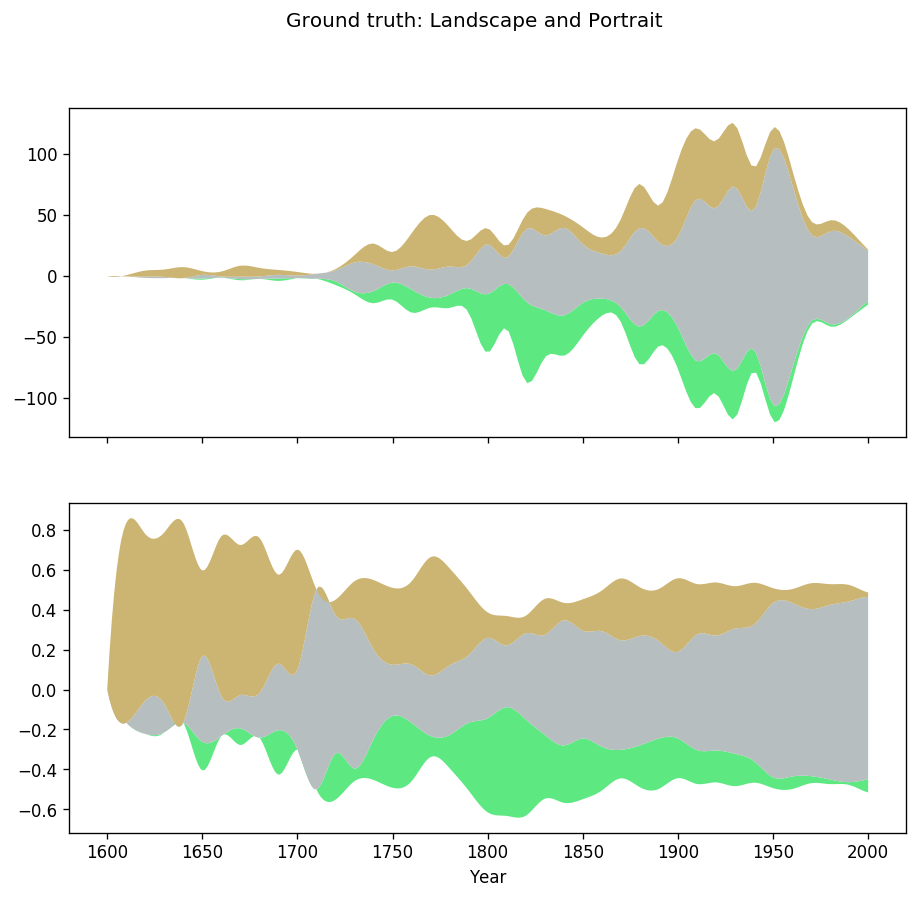

In [5]:
# Visualize ground truth

from scipy.interpolate import interp1d

iland = collection['groundtruth'] == 'L'
iport = collection['groundtruth'] == 'P'
irest = (~iland) & (~iport)

binned = (np.floor(collection['year'] / 10)*10).astype(int)

land = binned[iland].value_counts().sort_index()
port = binned[iport].value_counts().sort_index()
rest = binned[irest].value_counts().sort_index()

index = list(range(1600,2020,10))

land = land.reindex(index, fill_value=0)
port = port.reindex(index, fill_value=0)
rest = rest.reindex(index, fill_value=0)


fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(9,8), dpi=120, sharex=True)

# Plot smoothed stack plot
x = np.linspace(1600, 2000, 4*((200-160)+1), endpoint=True)
ax1.stackplot(x, [interp1d(index, land.values, kind='cubic')(x), 
                 interp1d(index, rest.values, kind='cubic')(x), 
                 interp1d(index, port.values, kind='cubic')(x)], 
                 colors=[cland,crest, cport],
                 baseline='wiggle')


# Relative values
_sum = land+port+rest
land = (land/_sum).fillna(0)
port = (port/_sum).fillna(0)
rest = (rest/_sum).fillna(0)

x = np.linspace(1600, 2000, 8*((200-160)+1), endpoint=True)
ax2.stackplot(x, [interp1d(index, land.values, kind='cubic')(x), 
                 interp1d(index, rest.values, kind='cubic')(x), 
                 interp1d(index, port.values, kind='cubic')(x)], 
                 colors=[cland,crest, cport],
                 baseline='wiggle')

# ax.hist(data, color=cols, bins=bins)
ax2.set_xlabel('Year')
fig.suptitle('Ground truth: Landscape and Portrait')

pass


<h2>Classify pictures by aspect ratio</h2>

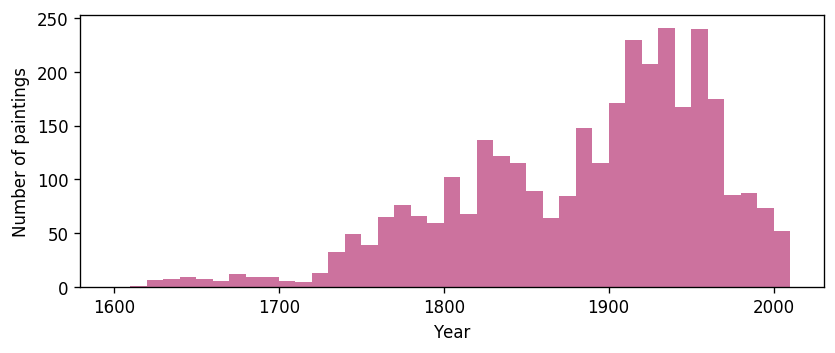

In [6]:
fig, ax = plt.subplots(figsize=(8,3), dpi=120)
ax.hist(collection['year'], bins=range(1600,2020,10), color=cdefault)
ax.set_xlabel('Year')
ax.set_ylabel('Number of paintings')
pass

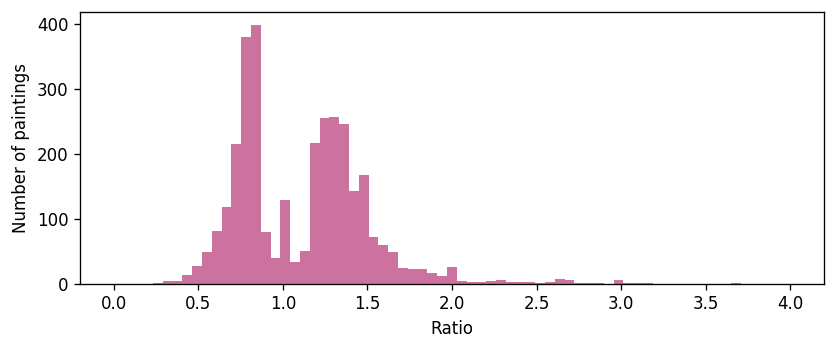

In [7]:
fig, ax = plt.subplots(figsize=(8,3), dpi=120)
ax.hist(collection['ratio'], bins=np.linspace(0,4,70), color=cdefault)
ax.set_xlabel('Ratio')
ax.set_ylabel('Number of paintings')
pass

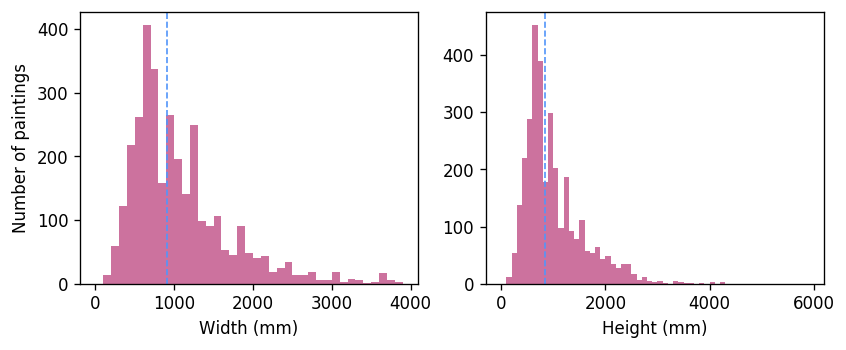

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), dpi=120)
ax1.hist(collection['width'], bins=range(0,4000,100), color=cdefault)
ax1.set_xlabel('Width (mm)')
ax1.set_ylabel('Number of paintings')
ax1.axvline( collection['width'].median(), color=chigh, ls='--', lw=1 )

ax2.hist(collection['height'], bins=range(0,6000,100), color=cdefault)
ax2.set_xlabel('Height (mm)')
ax2.axvline( collection['height'].median(), color=chigh, ls='--', lw=1 )
pass

In [9]:
import matplotlib.ticker



iland = collection['ratio'] >= 1.2
iport = collection['ratio'] <= .8
irest = (~iland) & (~iport)

classifiers['simple'] = ['O'] * len(classifiers)

classifiers.loc[iland,'simple'] = 'L'
classifiers.loc[iport,'simple'] = 'P'

classifiers

,groundtruth,simple
N01506,O,L
T13896,L,L
T05010,O,O
N01615,O,O
T02343,O,L
...,...,...
N05609,O,P
T14823,P,O
AL00397,O,L
T14824,P,O


Classified as landscape: 1564 (47.93%)
Classified as portrait: 791 (24.24%)
Unclassified: 908 (27.83%)


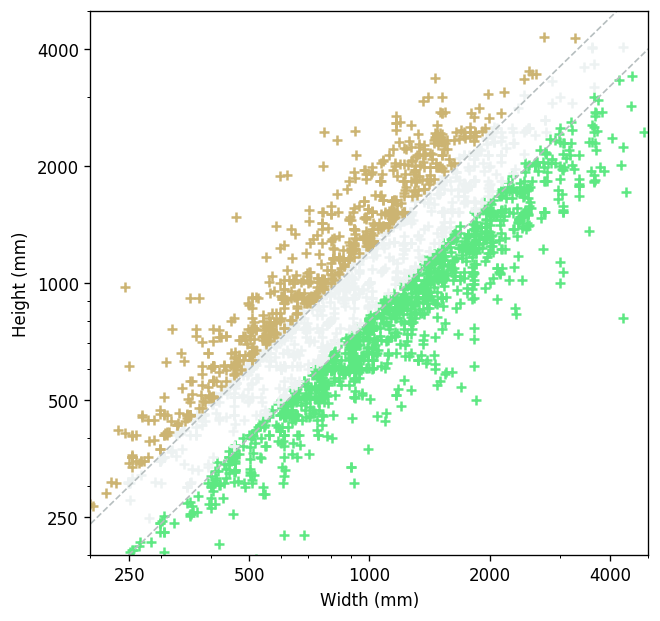

In [10]:
fig, ax = plt.subplots(figsize=(6,6), dpi=120)

n = len(iland)
c = np.sum(iland)
print("Classified as landscape: {} ({:.2f}%)".format(c, 100*c/n ))
c = np.sum(iport)
print("Classified as portrait: {} ({:.2f}%)".format(c, 100*c/n ))
c = np.sum(irest)
print("Unclassified: {} ({:.2f}%)".format(c, 100*c/n ))

ax.set_xlabel('Width (mm)')
ax.set_ylabel('Height (mm)')

ax.set_xlim(200, 5000)
ax.set_ylim(200, 5000)

ax.set_xscale('log')
ax.set_yscale('log')

ax.scatter(collection[iland]['width'], collection[iland]['height'], marker='+', c=cland)
ax.scatter(collection[irest]['width'], collection[irest]['height'], marker='+', c=crestlight)
ax.scatter(collection[iport]['width'], collection[iport]['height'], marker='+', c=cport)


ax.plot([200,5000], [200*1.2,5000*1.2], color=crest, ls='--', lw=1 )
ax.plot([200,5000], [200*.8,5000*.8], color=crest, ls='--', lw=1 )

# ax.get_xaxis().get_major_formatter().labelOnlyBase = False
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks([250, 500,1000,2000,4000])
ax.set_yticks([250, 500,1000,2000,4000])

pass

Classified as landscape: 1564 (47.93%)
Classified as portrait: 791 (24.24%)
Unclassified: 908 (27.83%)


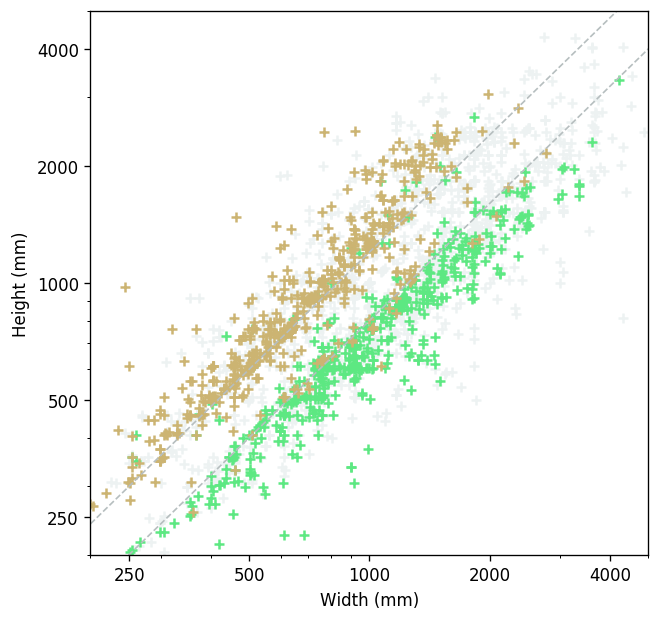

In [11]:
import matplotlib.ticker

fig, ax = plt.subplots(figsize=(6,6), dpi=120)

itland = collection['groundtruth'] == 'L'
itport = collection['groundtruth'] == 'P'
itrest = (~itland) & (~itport)

n = len(iland)
c = np.sum(iland)
print("Classified as landscape: {} ({:.2f}%)".format(c, 100*c/n ))
c = np.sum(iport)
print("Classified as portrait: {} ({:.2f}%)".format(c, 100*c/n ))
c = np.sum(irest)
print("Unclassified: {} ({:.2f}%)".format(c, 100*c/n ))

ax.set_xlabel('Width (mm)')
ax.set_ylabel('Height (mm)')

ax.set_xlim(200, 5000)
ax.set_ylim(200, 5000)

ax.set_xscale('log')
ax.set_yscale('log')

ax.scatter(collection[itrest]['width'], collection[itrest]['height'], marker='+', c=crestlight)
ax.scatter(collection[itland]['width'], collection[itland]['height'], marker='+', c=cland)
ax.scatter(collection[itport]['width'], collection[itport]['height'], marker='+', c=cport)


ax.plot([200,5000], [200*1.2,5000*1.2], color=crest, ls='--', lw=1 )
ax.plot([200,5000], [200*.8,5000*.8], color=crest, ls='--', lw=1 )

# ax.get_xaxis().get_major_formatter().labelOnlyBase = False
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks([250, 500,1000,2000,4000])
ax.set_yticks([250, 500,1000,2000,4000])

pass

<h2>Classify by title</h2>

In [13]:
from collections import Counter
titles = collection['title'].str.lower()

wordcount = Counter()
for t in titles:
    for w in t.split():
        if len(w) >= 2:
            wordcount[w] += 1
    
remove = ['the', 'and', 'with', 'from', 'for', 'untitled', 'of', 'in', 'at', 'on', 'an', 'st', 'to', 'by']
for w in remove:
    wordcount[w] = 0
    
port_words = {'portrait', 'nude', 'bust', 'self-portrait', 'figure',
                'gentleman', 'mr', 'lord', 'count', 'sir', 'man', 'boy', 
                'dr', 'colonel',
                'mrs', 'miss', 'lady', 'dame', 'countess', 'duchess', 'woman', 'women', 'girl', 
                'husband', 'wife', 'father', 'mother', 'son', 'daughter', 'family',
                'brother', 'sister', 'child'}
land_words = {'view', 'landscape', 'house', 'church', 'mill',
              'church', 'cathedral', 'castle', 
              'bridge', 'river', 'lake', 'canal', 'channel', 'pier', 'harbour', 'thames',
              'boat', 'ship', 'beach', 'sea', 'bay', 'coast', 'cliff',
              'tree', 'flower', 'forest', 'wood', 'garden', 'park', 'meadow', 'field', 'farm',
              'mountain', 'hill', 
              'morning', 'evening', 'sunset', 'sunrise',
              'winter', 'summer', 'autumn', 'spring'}

iport = titles.str.contains('|'.join(port_words))
iland = titles.str.contains('|'.join(land_words)) 
irest = iport & iland
iport &= ~irest
iland &= ~irest

In [14]:
# Print titles of unrecognized pictures
temp = collection[collection['groundtruth'] == 'L']['title'].str.lower()

words = Counter()
for t in temp[~temp.str.contains('|'.join(land_words))].unique():
    words.update(t.split())

words.most_common()[10:20]

[('-', 6),
 ('to', 6),
 ('for', 6),
 ('de', 6),
 ('venice', 5),
 ('st', 5),
 ('off', 5),
 ('by', 4),
 ('la', 4),
 ('(after', 4)]

In [15]:
# Print titles of unrecognized pictures
temp = collection[collection['groundtruth'] == 'P']['title'].str.lower()

words = Counter()
for t in temp[~temp.str.contains('|'.join(port_words))].unique():
    words.update(t.split())

words.most_common()

[('the', 64),
 ('of', 28),
 ('a', 20),
 ('and', 12),
 ('thomas', 8),
 ('study', 6),
 ('john', 6),
 ('william', 6),
 ('in', 6),
 ('his', 5),
 ('as', 5),
 ('samuel', 5),
 ('james', 5),
 ('smith', 4),
 ('george', 4),
 ('head', 4),
 ('la', 3),
 ('from', 3),
 ('philip', 3),
 ('with', 3),
 ('edward', 3),
 ('young', 3),
 ('charles', 3),
 ('willo!', 3),
 ('innocence', 2),
 ('painter', 2),
 ('jean', 2),
 ('black', 2),
 ('vernon', 2),
 ('somerset', 2),
 ('model', 2),
 ('return', 2),
 ('‘for', 2),
 ('gainsborough', 2),
 ('vanessa', 2),
 ('le', 2),
 ('moore', 2),
 ('engraver', 2),
 ('constable', 2),
 ('max', 2),
 ('house', 2),
 ('beckford', 2),
 ('master', 2),
 ('henry', 2),
 ('david', 2),
 ('bride', 2),
 ('lilian', 2),
 ('benjamin', 2),
 ('richard', 2),
 ('no', 2),
 ('parker', 2),
 ('york', 2),
 ('michael', 2),
 ('parish', 2),
 ('earl', 2),
 ('myself', 2),
 ('prince', 2),
 ('veth', 2),
 ('first', 2),
 ('francis', 2),
 ('jacket', 2),
 ('rosalind', 2),
 ('rev.', 2),
 ('(?)', 2),
 ('r.a.', 2),
 ('on

In [22]:
classifiers['title'] = ['O'] * len(classifiers)

classifiers.loc[iland, 'title'] = 'L'
classifiers.loc[iport, 'title'] = 'P'

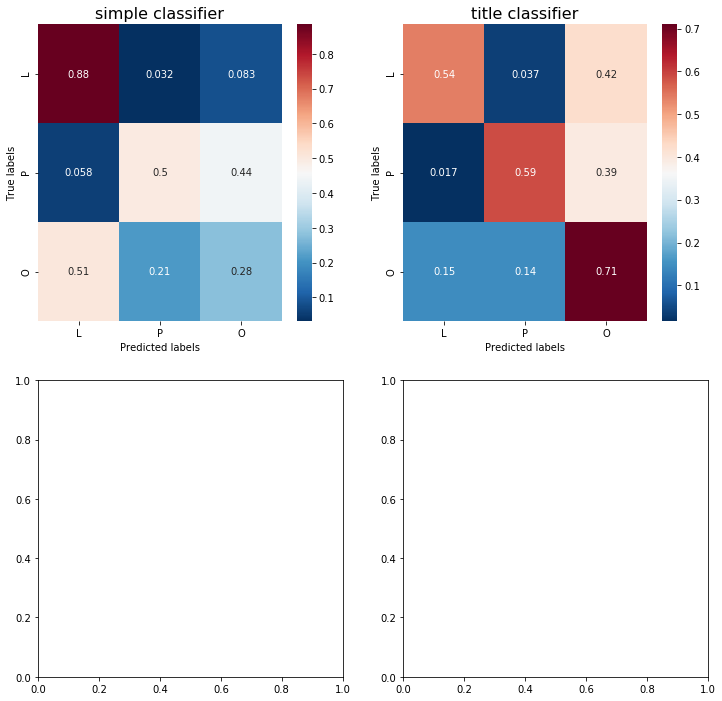

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion(pred):
    truth = collection['groundtruth']

    C = confusion_matrix(truth, pred, labels=['L','P','O'], normalize='true')

    fig, ax = plt.subplots(figsize=(6,4), dpi=120)
    sns.heatmap(C, annot=True, ax=ax, cmap="RdBu_r") 

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.xaxis.set_ticklabels(['L', 'P', 'O']);
    ax.yaxis.set_ticklabels(['L', 'P', 'O'])

    return fig, ax


fig, axes = plt.subplots(2,2,figsize=(12,12))
axes = axes.ravel()

    
k = len(classifiers.columns)-1 # Ignore groundtruth column
assert k <= 4
for c, ax in zip(classifiers.columns[1:], axes):
    C = confusion_matrix(classifiers['groundtruth'], classifiers[c], 
                          labels=['L','P','O'], normalize='true')
    sns.heatmap(C, annot=True, ax=ax, cmap="RdBu_r") 
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.xaxis.set_ticklabels(['L', 'P', 'O']);
    ax.yaxis.set_ticklabels(['L', 'P', 'O'])    
    ax.set_title(f'{c} classifier', fontsize=16); 
    



# fig, ax = plot_confusion(pred)
# ax.set_title('Confusion Matrix: ratio classifier'); 


## Explore relationship between colours and time

In [9]:
def parse_collist(filename):
    res = []
    with open(filename, 'r') as f:
        for l in f:
            col = [int(s) for s in l[:-1].split()]
            res.append(col)
    return np.array(res)

In [39]:
from scipy.spatial.distance import cdist
from itertools import combinations

indices = []
colors = []
for img_file in image_files():
    id = Path(img_file).stem
    
    if id not in collection.index:
        continue

    indices.append(id)
    colors.append(parse_collist('paintings/{}.txt'.format(id)))

colors = np.array(colors)
colors

array([array([[218, 181,  98],
       [217, 228, 241],
       [176, 187, 183],
       [219, 170, 156],
       [160,  74,   6],
       [107,  93,  90],
       [193, 128,   8],
       [144, 162, 161],
       [215, 158,  57],
       [212, 123, 105],
       [147,  69,  55],
       [194,  92,  54],
       [ 47,  26,  21]]),
       array([[212,  96, 124],
       [211, 163,   3],
       [212, 214, 213],
       [151, 157, 186],
       [237, 191, 152],
       [219, 106,  14],
       [  9,  56, 134],
       [188,   4,  40],
       [155,  87,   0],
       [156, 137, 126],
       [ 85,  47,  17],
       [ 83, 114, 185],
       [181, 129,  68],
       [ 39,  75, 160],
       [129,   2,  21],
       [ 58,  57,  58],
       [ 13,  31,  24]]),
       array([[255, 241, 219],
       [221,  91,  42],
       [252, 215, 139],
       [124, 143, 153],
       [207,  91,  97],
       [249, 181,  89],
       [235, 135, 135],
       [168, 164, 173],
       [250, 169, 158],
       [245, 131,  92],
       [145,   

In [40]:
from sklearn.cluster import MiniBatchKMeans

reduced = np.concatenate(colors, axis=0)
reduced = np.unique(reduced, axis=0)

clustering = MiniBatchKMeans(n_clusters=3000).fit(reduced)

/home/felix/.local/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=3000. Setting it to 3*k
  init_size=init_size)
/home/felix/.local/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=3000. Setting it to 3*k
  init_size=init_size)
/home/felix/.local/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=3000. Setting it to 3*k
  init_size=init_size)


In [41]:
clustering.cluster_centers_

array([[177. , 119. ,  30. ],
       [233. , 225. , 211. ],
       [117.5,  32.5,  28.5],
       ...,
       [122. , 109. ,  13. ],
       [181. ,  89. , 101. ],
       [131. , 134. , 140. ]])

In [42]:
from mpl_toolkits.mplot3d import Axes3D

colmap = dict(zip(indices,colors))

collection['century'] = collection['year']//100

print((collection['century'] == cent).values.shape)
print(colors.shape)

# for cent in sorted(collection['century'].unique())[2:-1]:
#     print(cent, np.sum(collection['century'] == cent))
#     colors[(collection['century'] == cent).values]

## Colours by type: not much structure.
# for G in 'PLO':
#     colset = set()
#     for ix in collection[collection.groundtruth == G].index:
#         if ix not in colmap:
#             continue
#         for col in colmap[ix]:
#             colset.add(tuple(col))

#     colset = [list(c) for c in colset]
#     colset = np.array(colset)

#     r, g, b = colset[:,0], colset[:,1], colset[:,2]
#     r = r.flatten()
#     g = g.flatten()
#     b = b.flatten()

#     fig = plt.figure(figsize=(12,12))
#     ax = Axes3D(fig)
#     ax.scatter(r, g, b, c=colset/255)
#     ax.set_title(G)
    
#     ax.view_init(azim=0, elev=0)




(3263,)
(3165,)


183.25015349393072

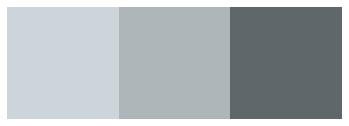

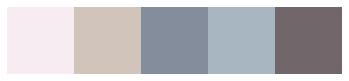

In [29]:
from scipy.optimize import linear_sum_assignment

def show_colors(cols):
    fig, ax = plt.subplots()
    ax.imshow([cols])
    ax.set_xticks([])
    ax.set_yticks([])
    for s in ax.spines:
        ax.spines[s].set_visible(False)
    return fig, ax    
    
    
def col_distance(colA,colB):
    """
        The distance is defined as the total sum of consecutive minimum matchings between
        the colours (where the weight corresponds to euclidean distance in RGB space).
        That is, we match colA against colB, then colB to the so far unmatched colours
        in colB, etc. until every colour in colB has been matched.
    """
    if len(colA) < len(colB):
        colA, colB = colB, colA
    
    C = cdist(colA,colB)

    dist = 0
    while C.shape[0] > 0:
        row_ind, col_ind = linear_sum_assignment(C) # Compute min weight matching
        
        dist += C[row_ind, col_ind].sum()
        C = np.delete(C, row_ind, axis=0) # Remove matched rows
    
    return dist

show_colors(colors[85])
show_colors(colors[208])

col_distance(colors[85], colors[208])

# counter = 10
# for i in range(len(colors)):
#     if len(colors[i]) > 5:
#         continue
    
#     counter -= 1
#     if counter <= 0:
#         break
#     fig, ax = show_colors(colors[i])
#     fig.suptitle(f'{i}')


In [78]:
filename = 'color_distance_matrix.txt'
    
if not Path(filename).is_file():
    print("Computing distance matrix")
    # Compute pairwise distance
    n = len(colors)
    D = np.zeros((n,n))
    for a,b in combinations(range(n), 2):
        d = col_distance(colors[a],colors[b])
        D[a][b] = d
        D[b][a] = d

    np.savetxt(filename, D)
else:
    print(f"Loading distance matrix from {filename}")

D = np.loadtxt(filename)

print(len(colors))
print(D)

Loading distance matrix from color_distance_matrix.txt
3165
[[   0.          999.32784501  667.61890426 ...  632.71145912
  1113.35664467  642.58575838]
 [ 999.32784501    0.          979.63940446 ...  864.99278875
  1403.22626879 1005.62562214]
 [ 667.61890426  979.63940446    0.         ...  963.8396453
   997.70328772  790.88729175]
 ...
 [ 632.71145912  864.99278875  963.8396453  ...    0.
  1508.51073223  801.00730381]
 [1113.35664467 1403.22626879  997.70328772 ... 1508.51073223
     0.          908.88262302]
 [ 642.58575838 1005.62562214  790.88729175 ...  801.00730381
   908.88262302    0.        ]]


In [55]:
print(np.min(D[D>0]))
print(np.max(D))

48.989675063691955
7391.085844372772


## Spectral clustering

In [150]:
from sklearn.cluster import SpectralClustering

delta = 70
K = np.exp(- D ** 2 / (2. * delta ** 2))
clustering = SpectralClustering(n_clusters=3, affinity='precomputed').fit(K)


values, counts = np.unique(clustering.labels_, return_counts=True)


relevant = sorted(zip(counts, values), reverse=True)
relevant = [c for c in relevant if c[0] >= 100]
print(relevant)

[(3163, 0)]


In [153]:
labels = np.copy(clustering.labels_)
ids = sorted(list(zip(values,counts)), key=lambda s: -s[1])

print(ids)

ser = pd.Series(index=indices, data=labels)
for i, c in ids:
    print(f"{i} ({c}):")
    I = ser == i
    counts = view[I]['groundtruth'].value_counts()
    print(100 * counts / np.sum(counts))

[(0, 1874), (1, 688), (2, 601)]
0 (1874):
O    59.247550
P    21.751502
L    19.000948
Name: groundtruth, dtype: float64
1 (688):
O    100.0
Name: groundtruth, dtype: float64
2 (601):
O    100.0
Name: groundtruth, dtype: float64


## Agglomerative clustering

Using a distance thresholds results in one big cluster and many small ones.
Fixing the number of clusters returns clusters not corresponding to the ground truth.

In [132]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=3, affinity='precomputed', 
                                     linkage="complete").fit(D)


print("Number of clusters:", clustering.n_clusters_)

values, counts = np.unique(clustering.labels_, return_counts=True)

relevant = sorted(zip(counts, values), reverse=True)
relevant = [c for c in relevant if c[0] >= 100]
print(relevant)

Number of clusters: 3
[(2030, 2), (1056, 1)]


In [133]:
labels = np.copy(clustering.labels_)
ids = sorted(list(zip(values,counts)), key=lambda s: -s[1])

ser = pd.Series(index=indices, data=labels)
for i, c in ids:
    print(f"{i} ({c}):")
    I = ser == i
    counts = view[I]['groundtruth'].value_counts()
    print(100 * counts / np.sum(counts))

2 (2030):
O    60.985222
L    21.133005
P    17.881773
Name: groundtruth, dtype: float64
1 (1056):
O    55.018939
P    30.018939
L    14.962121
Name: groundtruth, dtype: float64
0 (79):
O    72.151899
L    17.721519
P    10.126582
Name: groundtruth, dtype: float64


## Optics

Similar results to DBSCAN.

In [161]:
from sklearn.cluster import OPTICS

# Restrict dataset to those for which we have colours
view = collection.loc[indices]

for eps in range(200,400,50):
    print(eps)
    clustering = OPTICS(metric='precomputed', max_eps=eps, xi=0.9, min_cluster_size=100).fit(D)
    values, counts = np.unique(clustering.labels_, return_counts=True)

    print("{} clusters, noise {:.2f}%".format(len(values)-1, 100 * counts[0] / np.sum(counts)))
    if len(counts) > 1:
        print(100 * counts[1:] / np.sum(counts))

200
1 clusters, noise 81.99%
[18.00947867]
250
1 clusters, noise 69.67%
[30.33175355]
300
1 clusters, noise 56.97%
[43.03317536]
350
1 clusters, noise 46.35%
[53.6492891]


## DBSCAN

Result: to much connectivity, single cluster.

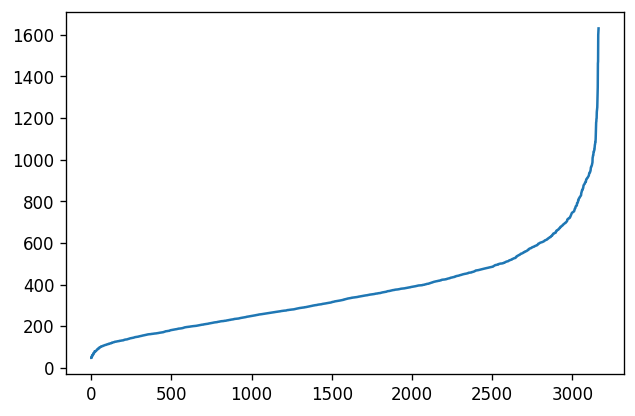

In [33]:
from sklearn.neighbors import NearestNeighbors


# Figure out good value for DBSCAN parameter eps.
# In the following plot, we find the y-value associates with the
# 'largest curvature'.
neigh = NearestNeighbors(n_neighbors=2, metric='precomputed')
nbrs = neigh.fit(D)
distances, _ = nbrs.kneighbors(D)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

fig, ax = plt.subplots(dpi=120)
ax.plot(distances)

In [77]:
from sklearn.cluster import DBSCAN

# Restrict dataset to those for which we have colours
view = collection.loc[indices]

# eps chosen so that 3 large clusters emerge
for eps in range(600,901,50):
    print(eps)
    clustering = DBSCAN(metric='precomputed', eps=eps, min_samples=2000).fit(D)
    values, counts = np.unique(clustering.labels_, return_counts=True)

    print("{} clusters, noise {:.2f}%".format(len(values)-1, 100 * counts[0] / np.sum(counts)))
    if len(counts) > 1:
        print(100 * counts[1:] / np.sum(counts))

600
0 clusters, noise 100.00%
650
1 clusters, noise 24.17%
[75.82938389]
700
1 clusters, noise 14.72%
[85.2764613]
750
1 clusters, noise 9.92%
[90.07898894]
800
1 clusters, noise 7.42%
[92.57503949]
850
1 clusters, noise 5.91%
[94.09162717]
900
1 clusters, noise 4.42%
[95.57661927]


In [80]:
labels = np.copy(clustering.labels_)
ids = sorted(list(zip(values,counts)), key=lambda s: -s[1])

print(ids)

ser = pd.Series(index=indices, data=labels)
for i, c in ids:
    if c < 100:
        break
    
    print(f"{i} ({c}):")
    I = ser == i
    counts = view[I]['groundtruth'].value_counts()
    print(100 * counts / np.sum(counts))

[(0, 3025), (-1, 140)]
0 (3025):
O    58.115702
P    22.479339
L    19.404959
Name: groundtruth, dtype: float64
-1 (140):
O    84.285714
L    10.000000
P     5.714286
Name: groundtruth, dtype: float64
